# Social dimension (Who)
* Misinformation detection exploiting user features
* Detection of malicious users: can we distinguish malicious from gullible users?
* Detection of superspreaders: abnormal rates of misinformation spread
* Detection of sources of misinformation: first users to share misinformation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import utils
from utils import preprocess
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from gensim.models import Word2Vec

%matplotlib inline
sns.set(style="darkgrid")

C:\Users\lucas.carneiro\Anaconda3\envs\env\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


## Load data users data

In [114]:
# users
df_users = pd.read_csv('data/2018/users.csv')

# credibility score with laplace smoothing

df_users['credibility'] = 1-df_users['misinformation']/(df_users['virals']+1)
df_users = df_users.rename(columns={"misinformation": "misinformations"})
print(df_users.columns)
df_users

Index(['id', 'groups', 'number_of_messages', 'texts', 'text_ratio', 'midia',
       'midia_ratio', 'virals', 'viral_ratio', 'repeated_messages',
       'repeated_messages_ratio', 'days_active', 'daily_mean', 'daily_std',
       'daily_median', 'daily_95', 'daily_outliers', 'degree_centrality',
       'strenght', 'viral_degree_centrality', 'viral_strenght',
       'misinformations', 'misinformation_degree_centrality',
       'misinformation_strenght', 'misinformation_ratio',
       'viral_misinformation_ratio', 'credibility'],
      dtype='object')


,id,groups,number_of_messages,texts,text_ratio,midia,midia_ratio,virals,viral_ratio,repeated_messages,...,degree_centrality,strenght,viral_degree_centrality,viral_strenght,misinformations,misinformation_degree_centrality,misinformation_strenght,misinformation_ratio,viral_misinformation_ratio,credibility
0,-3818310068976662355,1,4396,3742,0.851228,654,0.148772,24,0.005460,609,...,153,672588,153,3672,10,153,1530,0.002275,0.416667,0.600000
1,5782050016593913959,11,2332,972,0.416810,1360,0.583190,227,0.097341,363,...,1710,498161,1631,48057,58,1506,11907,0.024871,0.255507,0.745614
2,-2072140886659020977,3,2064,948,0.459302,1116,0.540698,243,0.117733,94,...,534,391490,534,46414,85,534,15800,0.041182,0.349794,0.651639
3,2839535797075678550,5,2020,1587,0.785644,433,0.214356,116,0.057426,258,...,895,644390,895,30154,25,866,6179,0.012376,0.215517,0.786325
4,170916900626840870,1,1810,828,0.457459,982,0.542541,111,0.061326,24,...,153,276930,153,16983,69,153,10557,0.038122,0.621622,0.383929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5359,-3685511676029813622,1,1,0,0.000000,1,1.000000,0,0.000000,0,...,166,166,0,0,0,0,0,0.000000,0.000000,1.000000
5360,-3687281691650946329,1,1,0,0.000000,1,1.000000,0,0.000000,0,...,188,188,0,0,0,0,0,0.000000,0.000000,1.000000
5361,4870300454101875011,1,1,1,1.000000,0,0.000000,0,0.000000,0,...,57,57,0,0,0,0,0,0.000000,0.000000,1.000000
5362,7020988212245908273,1,1,1,1.000000,0,0.000000,0,0.000000,0,...,91,91,0,0,0,0,0,0.000000,0.000000,1.000000


# Associate misinformation with information of the first user that shared

In [115]:

# dataset with labelled data
df = pd.read_csv('data/2018/fakeWhatsApp.BR_2018.csv')

# select only labelled data
# df = pd.read_csv('data/2018/fakeWhatsApp.BR_2018.csv')
df = df[df['midia']==0]
df = df[df['misinformation']!=-1]

# sorting by time
def custom_time(data,hora):
    string = data + " " + hora
    return string

df['timestamp'] = df.apply(lambda x: custom_time(x['date'],x['hour']),axis=1)
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%d/%m/%y %H:%M')
df.sort_values(by='timestamp',inplace=True)
df = df[['id','text','misinformation', 'timestamp']]

df_full = df.copy()
df.drop_duplicates(subset='text', inplace = True)

df['label'] = ['misinformation' if m == 1 else 'non-misinformation' for m in df['misinformation']]
print(len(df))
df.reset_index(drop=True,inplace=True)
df.head()

C:\Users\lucas.carneiro\Anaconda3\envs\env\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (4,7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


6926


,id,text,misinformation,timestamp,label
0,6942577183305588053,"O dia em que ex-guerrilheiro, militantes e des...",1,2018-07-02 10:46:00,misinformation
1,-2072140886659020977,O nível dos jornalistas do programa Roda Viva ...,1,2018-07-02 10:50:00,misinformation
2,-5100443702615645928,*Atenção*\n\nPrecisamos da ajuda de todos você...,0,2018-07-02 11:03:00,non-misinformation
3,-1561843698204261697,"Gestão do colombiano na capital, imagina ele n...",1,2018-07-02 16:31:00,misinformation
4,-5876784761398352499,🛑🛑🛑🛑🛑🛑\nInterrompendo momentaneamente a conver...,1,2018-07-02 18:09:00,misinformation


## Get mean features from all users who shared the message

In [123]:
m = df['text'][2]
k = 3
user_features = df_users.columns[1:]
df_user_features = pd.DataFrame()

users = df_full[df_full['text']==m].sort_values(by='timestamp')
users = list((users['id']))
print(users)

df_users_shared_line = pd.DataFrame()
for i in range(k): # u in users
    try:
        u = users[i]        
        line = df_users[df_users['id']==u][user_features].reset_index(drop=True)
    except:
        line = pd.DataFrame(np.zeros((1, len(user_features))), columns = user_features)
    
    df_users_shared_line = pd.concat([df_users_shared_line, line], axis = 1)


df_users_shared_line

[-5100443702615645928, -5100443702615645928]


,groups,number_of_messages,texts,text_ratio,midia,midia_ratio,virals,viral_ratio,repeated_messages,repeated_messages_ratio,...,degree_centrality,strenght,viral_degree_centrality,viral_strenght,misinformations,misinformation_degree_centrality,misinformation_strenght,misinformation_ratio,viral_misinformation_ratio,credibility
0,1,340,266,0.782353,74,0.217647,76,0.223529,6,0.022556,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [124]:
k = 3
user_features = df_users.columns[1:]
df_user_features = pd.DataFrame()

for m in df['text']:
    users = df_full[df_full['text']==m].sort_values(by='timestamp')
    users = list((users['id']))

    df_users_shared_line = pd.DataFrame()
    for i in range(k): # u in users
        try:
            u = users[i]        
            line = df_users[df_users['id']==u][user_features].reset_index(drop=True)
        except:
            line = pd.DataFrame(np.zeros((1, len(user_features))), columns = user_features)

        df_users_shared_line = pd.concat([df_users_shared_line, line], axis = 1)
    
    df_user_features = pd.concat([df_user_features, df_users_shared_line])

df_user_features = df_user_features.reset_index(drop=True)
df = pd.concat([df,df_user_features], axis = 1)

In [125]:
df

,id,text,misinformation,timestamp,label,groups,number_of_messages,texts,text_ratio,midia,...,degree_centrality,strenght,viral_degree_centrality,viral_strenght,misinformations,misinformation_degree_centrality,misinformation_strenght,misinformation_ratio,viral_misinformation_ratio,credibility
0,6942577183305588053,"O dia em que ex-guerrilheiro, militantes e des...",1,2018-07-02 10:46:00,misinformation,1,31,4,0.129032,27,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
1,-2072140886659020977,O nível dos jornalistas do programa Roda Viva ...,1,2018-07-02 10:50:00,misinformation,3,2064,948,0.459302,1116,...,273.0,127491.0,273.0,11466.0,20.0,273.0,5460.0,0.042827,0.476190,0.534884
2,-5100443702615645928,*Atenção*\n\nPrecisamos da ajuda de todos você...,0,2018-07-02 11:03:00,non-misinformation,1,340,266,0.782353,74,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
3,-1561843698204261697,"Gestão do colombiano na capital, imagina ele n...",1,2018-07-02 16:31:00,misinformation,6,78,50,0.641026,28,...,739.0,13472.0,739.0,5505.0,12.0,739.0,1843.0,0.153846,0.387097,0.625000
4,-5876784761398352499,🛑🛑🛑🛑🛑🛑\nInterrompendo momentaneamente a conver...,1,2018-07-02 18:09:00,misinformation,2,63,35,0.555556,28,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6921,9168025156996167745,EM GRATIDÃO... PEDIMOS AO POVO BRASILEIRO QUE ...,0,2018-10-28 18:53:00,non-misinformation,1,31,12,0.387097,19,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
6922,-5542692723449689572,Que Deus ilumine o novo presidente. É um alívi...,0,2018-10-28 19:24:00,non-misinformation,1,42,24,0.571429,18,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
6923,-6076734346383138898,Contra TD e contra todos... Mostramos q o Bras...,0,2018-10-28 19:27:00,non-misinformation,1,14,11,0.785714,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
6924,2485357201479715834,OLHA O QUANTO AVANÇAMOS! SE LIGA NESSA LIMPEZA...,1,2018-10-28 21:53:00,misinformation,1,327,81,0.247706,246,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000


## Feature engineering

In [126]:
df.columns

Index(['id', 'text', 'misinformation', 'timestamp', 'label', 'groups',
       'number_of_messages', 'texts', 'text_ratio', 'midia', 'midia_ratio',
       'virals', 'viral_ratio', 'repeated_messages', 'repeated_messages_ratio',
       'days_active', 'daily_mean', 'daily_std', 'daily_median', 'daily_95',
       'daily_outliers', 'degree_centrality', 'strenght',
       'viral_degree_centrality', 'viral_strenght', 'misinformations',
       'misinformation_degree_centrality', 'misinformation_strenght',
       'misinformation_ratio', 'viral_misinformation_ratio', 'credibility',
       'groups', 'number_of_messages', 'texts', 'text_ratio', 'midia',
       'midia_ratio', 'virals', 'viral_ratio', 'repeated_messages',
       'repeated_messages_ratio', 'days_active', 'daily_mean', 'daily_std',
       'daily_median', 'daily_95', 'daily_outliers', 'degree_centrality',
       'strenght', 'viral_degree_centrality', 'viral_strenght',
       'misinformations', 'misinformation_degree_centrality',
      

In [127]:
user_features = ['groups', 'number_of_messages', 'texts', 'text_ratio', 'midia', 'midia_ratio',
       'virals', 'viral_ratio', 'repeated_messages', 'repeated_messages_ratio',
       'days_active', 'daily_mean', 'daily_median', 'daily_95',
       'daily_outliers', 'degree_centrality', 'strenght',
       'viral_degree_centrality', 'viral_strenght']
X = df[user_features]
y = df['misinformation']
X.shape

(6926, 57)

[0.00740479 0.00447039 0.00222134 0.02245818 0.01619943 0.00610782
 0.0184463  0.00934307 0.00161    0.03212022 0.034978   0.00993726
 0.02683406 0.01766913 0.00836732 0.04255739 0.02234511 0.02053358
 0.02553075 0.01207738 0.01895259 0.0502556  0.01967685 0.00680708
 0.01339651 0.01252151 0.00965182 0.05772493 0.01709139 0.00525549
 0.03346414 0.02172538 0.00304215 0.03455993 0.0189556  0.01536532
 0.01572166 0.00582187 0.00292915 0.03144424 0.01545707 0.0054897
 0.00805215 0.00954969 0.00615104 0.02240728 0.02176603 0.00473198
 0.03748403 0.01731475 0.00553627 0.0338255  0.01902339 0.00639816
 0.02768053 0.01586084 0.00769688]


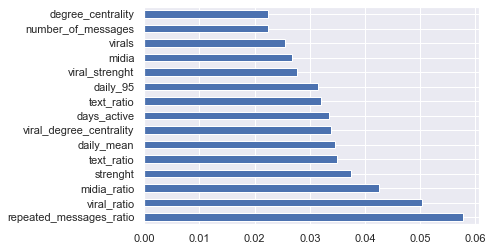

In [78]:
# feature importance
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.show()

In [80]:
list(feat_importances.nlargest(50).index)

['repeated_messages_ratio',
 'viral_ratio',
 'midia_ratio',
 'strenght',
 'text_ratio',
 'daily_mean',
 'viral_degree_centrality',
 'days_active',
 'text_ratio',
 'daily_95',
 'viral_strenght',
 'midia',
 'virals',
 'number_of_messages',
 'degree_centrality',
 'midia_ratio',
 'degree_centrality',
 'days_active',
 'midia_ratio',
 'viral_ratio',
 'viral_degree_centrality',
 'daily_mean',
 'virals',
 'texts',
 'midia',
 'strenght',
 'repeated_messages_ratio',
 'number_of_messages',
 'viral_strenght',
 'daily_median',
 'daily_95',
 'daily_mean',
 'repeated_messages',
 'repeated_messages',
 'virals',
 'text_ratio',
 'repeated_messages',
 'daily_outliers',
 'texts',
 'midia',
 'daily_outliers',
 'viral_strenght',
 'groups',
 'viral_ratio',
 'viral_degree_centrality',
 'daily_outliers',
 'number_of_messages',
 'daily_median',
 'strenght',
 'daily_95']

In [128]:
user_classification_features = ['repeated_messages_ratio',
 'viral_ratio',
 'strenght',
 'text_ratio',
 'daily_95',
 'midia',
 'viral_strenght',
 'daily_mean',
 'daily_outliers',
 'degree_centrality']

# Exploiting user information to detect misinformation

In [83]:
# messages
df_train = pd.read_csv('data/2018/train-test/train.csv')
df_test = pd.read_csv('data/2018/train-test/test.csv')

In [58]:
# df_train['preprocessed_text'] = [preprocess(t) for t in df_train['text']]
# df_test['preprocessed_text'] = [preprocess(t) for t in df_test['text']]
# df_train.to_csv('data/2018/train-test/train.csv', index = False)
# df_test.to_csv('data/2018/train-test/test.csv', index = False)

In [94]:
# user_classification_features = ['groups', 'number_of_messages', 'midia_ratio',
#        'viral_ratio', , 'degree_centrality', 'strenght',
#        'viral_degree_centrality', 'viral_strenght']

#user_classification_features = ['midia_ratio', 'viral_ratio', 'repeated_messages_ratio']

def acquire_user_info(df_target, df_origin):   

    
    df_user_features = pd.DataFrame()
    

    for m in df_target['text']:
        user_info = df_origin[df_origin['text']==m]
        user_info.sort_values(by='timestamp')        
        user_info = user_info[0:1]        
        user_info = user_info[user_classification_features]
        df_user_features = pd.concat([df_user_features, user_info])
        
    df_user_features.reset_index(drop= True, inplace = True)
    df_target = pd.concat([df_target, df_user_features], axis = 1)
    return df_target

df_train = acquire_user_info(df_train, df)
df_test = acquire_user_info(df_test, df)    

In [95]:
df_train.head()

,text,misinformation,original,id_message,preprocessed_text,repeated_messages_ratio,repeated_messages_ratio,repeated_messages_ratio,viral_ratio,viral_ratio,...,viral_strenght,daily_mean,daily_mean,daily_mean,daily_outliers,daily_outliers,daily_outliers,degree_centrality,degree_centrality,degree_centrality
0,A ESQUERDA ACABOU. SAIBA POR QUÊ.\npor Stephen...,1,1,0,esquerdo acabar saber que \n stephen kanitz ar...,0.032258,0.000000,0.0,0.177305,0.000000,...,0.0,1.205128,0.000000,0.000000,2.0,0.0,0.0,57.0,0.0,0.0
1,Leiam esse artigo \n\n\nA ESQUERDA ACABOU. SAI...,1,0,0,ler artigo \n \n \n esquerdo acabar saber que ...,0.412993,0.000000,0.0,0.397472,0.000000,...,0.0,9.128205,0.000000,0.000000,4.0,0.0,0.0,1080.0,0.0,0.0
2,A ESQUERDA ACABOU. SAIBA POR QUÊ?\npor Stephen...,1,0,0,esquerdo acabar saber que ? \n stephen kanitz ...,0.030769,0.000000,0.0,0.142268,0.000000,...,0.0,13.857143,0.000000,0.000000,2.0,0.0,0.0,91.0,0.0,0.0
3,A ESQUERDA ACABOU. SAIBA POR QUÊ.\npor Stephen...,1,0,0,esquerdo acabar saber que \n stephen kanitz \n...,0.102190,0.020408,0.0,0.069252,0.105691,...,159.0,4.878378,3.671642,0.218182,3.0,3.0,2.0,270.0,105.0,53.0
4,A ESQUERDA ACABOU. SAIBA POR QUÊ.\npor Stephen...,1,0,0,esquerdo acabar saber que \n stephen kanitz \n...,0.025641,0.000000,0.0,0.190244,0.000000,...,0.0,1.737288,0.000000,0.000000,6.0,0.0,0.0,148.0,0.0,0.0


In [129]:
# include viral strenght
# X_train = df_train[['midia_ratio','viral_ratio', 'viral_strenght']].to_numpy()
# X_test = df_test[['midia_ratio','viral_ratio', 'viral_strenght']].to_numpy()
# y_train = df_train['misinformation']
# y_test = df_test['misinformation']
# X_train,X_test = utils.z_score(X_train,X_test)
# X_train.shape


X_train = df_train[user_classification_features].to_numpy()
X_train = np.array(X_train, dtype=np.float64)
X_test = df_test[user_classification_features].to_numpy()
X_test = np.array(X_test, dtype=np.float64)
y_train = df_train['misinformation']
y_test = df_test['misinformation']

X_train_u, X_test_u = utils.z_score(X_train, X_test)
X_train, X_test = utils.z_score(X_train, X_test)

print('train', X_train.shape)
print('test', X_test.shape)

# with open('train_user_features.npy', 'wb') as f:
#     np.save(f, X_train)
    
# with open('test_user_features.npy', 'wb') as f:
#     np.save(f, X_test)

train (6233, 30)
test (1574, 30)


logistic regression + user info
0.49
              precision    recall  f1-score   support

           0       0.62      0.63      0.62       834
           1       0.57      0.56      0.57       740

    accuracy                           0.60      1574
   macro avg       0.59      0.59      0.59      1574
weighted avg       0.60      0.60      0.60      1574

AUC:  0.6306184781904207


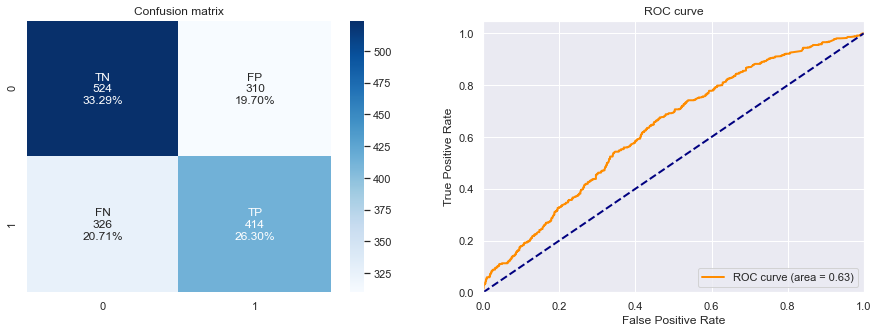

0,595
0,377
0,571
0,559
0,565
0,630


(0.5959339263024143,
 0.3776722090261282,
 0.5718232044198895,
 0.5594594594594594,
 0.5655737704918032,
 0.6306184781904207)

In [130]:
print('logistic regression + user info')
lr = LogisticRegression()
lr.fit(X_train, y_train)

y_prob = lr.predict_proba(X_test)[:,1]
y_prob_train = lr.predict_proba(X_train)[:,1]
# threshold moving

thr = utils.optimal_threshold(y_prob_train, y_train)
print(thr)
y_pred = [1 if p >= thr else 0 for p in y_prob]
utils.get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)

mlp + user
0 
hidden layers: (150,); alpha: 0.00238; learning rate: 0.03748; batch: 100
ACC: 0.587
1 
hidden layers: (75, 125); alpha: 0.00002; learning rate: 0.00015; batch: 250
ACC: 0.596
2 
hidden layers: (50, 175, 200); alpha: 0.00013; learning rate: 0.00506; batch: 300
ACC: 0.587
3 
hidden layers: (350, 225); alpha: 0.00000; learning rate: 0.00011; batch: 200
ACC: 0.585
4 
hidden layers: (25, 75); alpha: 0.00008; learning rate: 0.02528; batch: 300
ACC: 0.574

--------------------
BEST PARAMETERS (validation AUC = 0.596)
hidden layers: (75, 125); alpha: 0.00002; learning rate: 0.00015; batch: 250
--------------------
0.5
              precision    recall  f1-score   support

           0       0.61      0.66      0.64       834
           1       0.58      0.53      0.56       740

    accuracy                           0.60      1574
   macro avg       0.60      0.60      0.60      1574
weighted avg       0.60      0.60      0.60      1574

AUC:  0.6484639315574567


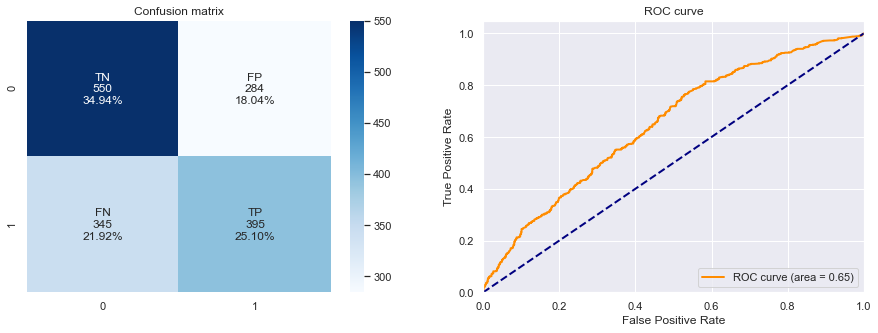

0,600
0,363
0,581
0,533
0,556
0,648


(0.6003811944091486,
 0.3637941006362059,
 0.5817378497790869,
 0.5337837837837838,
 0.5567300916138125,
 0.6484639315574567)

In [131]:
print('mlp + user')
hl,bs,al,lri = utils.random_search_mlp(X_train,y_train,n_iter=5)
clf = utils.optimized_mlp(hl,bs,al,lri)
clf.fit(X_train, y_train)

y_prob = clf.predict_proba(X_test)[:,1]
y_prob_train = clf.predict_proba(X_train)[:,1]
# threshold moving

thr = utils.optimal_threshold(y_prob_train, y_train)
print(thr)
y_pred = [1 if p >= thr else 0 for p in y_prob]
utils.get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)

# Combining with text

## User + Word2Vec

In [132]:
w2v = Word2Vec.load("data/2018/word2vec.model")
X_train_w = utils.vectorize_corpus(w2v, df_train['preprocessed_text'])
X_test_w = utils.vectorize_corpus(w2v, df_test['preprocessed_text'])

In [133]:
X_train = np.concatenate((X_train_w, X_train_u), axis=1)
X_test = np.concatenate((X_test_w, X_test_u), axis=1)

logistic regression + user info + w2v


C:\Users\lucas.carneiro\Anaconda3\envs\env\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.47
              precision    recall  f1-score   support

           0       0.77      0.71      0.74       834
           1       0.70      0.76      0.73       740

    accuracy                           0.74      1574
   macro avg       0.74      0.74      0.74      1574
weighted avg       0.74      0.74      0.74      1574

AUC:  0.8102112904271177


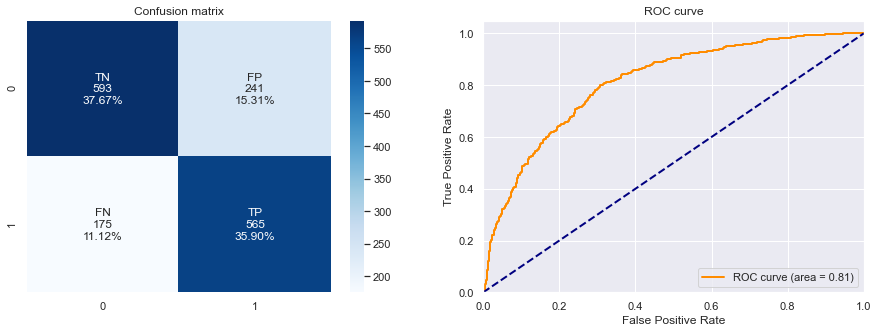

0,735
0,259
0,700
0,763
0,730
0,810


(0.735705209656925,
 0.25967540574282133,
 0.7009925558312655,
 0.7635135135135135,
 0.7309184993531694,
 0.8102112904271177)

In [134]:
print('logistic regression + user info + w2v')
lr = LogisticRegression()
lr.fit(X_train, y_train)

y_prob = lr.predict_proba(X_test)[:,1]
y_prob_train = lr.predict_proba(X_train)[:,1]
# threshold moving

thr = utils.optimal_threshold(y_prob_train, y_train)
print(thr)
y_pred = [1 if p >= thr else 0 for p in y_prob]
utils.get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)

mlp + user + w2v
0 
hidden layers: (150,); alpha: 0.00238; learning rate: 0.03748; batch: 100
ACC: 0.760
1 
hidden layers: (75, 125); alpha: 0.00002; learning rate: 0.00015; batch: 250
ACC: 0.692
2 
hidden layers: (50, 175, 200); alpha: 0.00013; learning rate: 0.00506; batch: 300
ACC: 0.771
3 
hidden layers: (350, 225); alpha: 0.00000; learning rate: 0.00011; batch: 200
ACC: 0.760
4 
hidden layers: (25, 75); alpha: 0.00008; learning rate: 0.02528; batch: 300
ACC: 0.774
5 
hidden layers: (200, 25, 50); alpha: 0.00000; learning rate: 0.06823; batch: 150
ACC: 0.721
6 
hidden layers: (200,); alpha: 0.00001; learning rate: 0.02102; batch: 250
ACC: 0.774
7 
hidden layers: (25, 25, 125); alpha: 0.00030; learning rate: 0.00686; batch: 250
ACC: 0.737
8 
hidden layers: (125, 250); alpha: 0.00006; learning rate: 0.00691; batch: 100
ACC: 0.747
9 
hidden layers: (200, 250); alpha: 0.00757; learning rate: 0.00911; batch: 200
ACC: 0.787

--------------------
BEST PARAMETERS (validation AUC = 0.787)
h

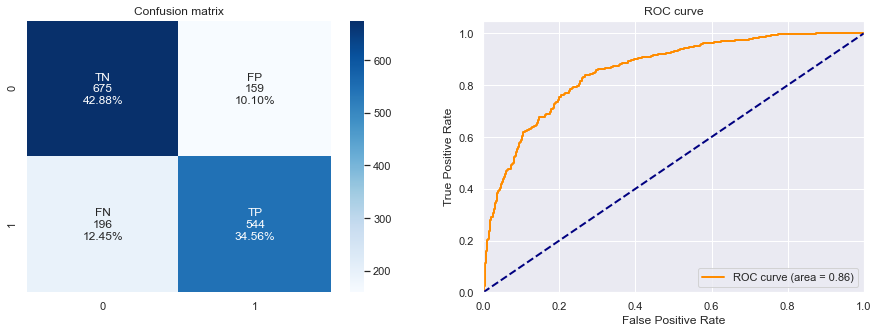

0,774
0,208
0,773
0,735
0,753
0,856


(0.7744599745870394,
 0.2082111436950147,
 0.7738264580369844,
 0.7351351351351352,
 0.753984753984754,
 0.8565995851967074)

In [135]:
print('mlp + user + w2v')
hl,bs,al,lri = utils.random_search_mlp(X_train,y_train,n_iter=10)
clf = utils.optimized_mlp(hl,bs,al,lri)
clf.fit(X_train, y_train)

y_prob = clf.predict_proba(X_test)[:,1]
y_prob_train = clf.predict_proba(X_train)[:,1]
# threshold moving

thr = utils.optimal_threshold(y_prob_train, y_train)
print(thr)
y_pred = [1 if p >= thr else 0 for p in y_prob]
utils.get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)

## TF-IDF + users

In [136]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
tfidf = TfidfVectorizer(max_features = None, ngram_range = (1,1), #(1,3)  #15000
                             lowercase = False, token_pattern = r'[^\s]+', binary=False)

tfidf.fit(df_train['preprocessed_text'])   
X_train_tfidf = tfidf.transform(df_train['preprocessed_text']).todense()
X_test_tfidf = tfidf.transform(df_test['preprocessed_text']).todense()
X_train_tfidf.shape

(6233, 17525)

In [137]:
X_train = np.concatenate((X_train_tfidf, X_train_u), axis=1)
X_test = np.concatenate((X_test_tfidf, X_test_u), axis=1)

logistic regression + user info + tfidf


C:\Users\lucas.carneiro\Anaconda3\envs\env\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.48
              precision    recall  f1-score   support

           0       0.80      0.81      0.81       834
           1       0.78      0.77      0.78       740

    accuracy                           0.79      1574
   macro avg       0.79      0.79      0.79      1574
weighted avg       0.79      0.79      0.79      1574

AUC:  0.8669939723896557


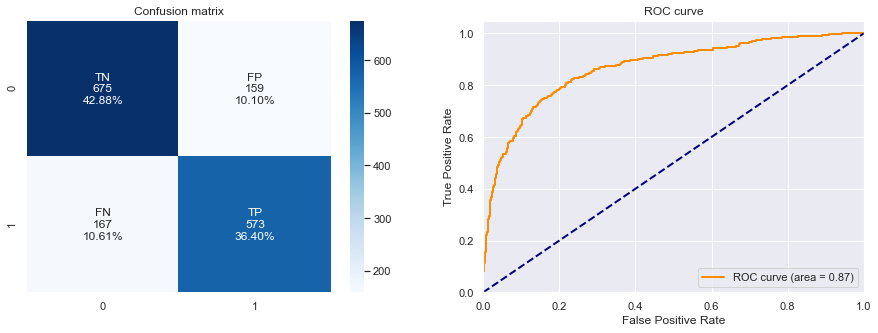

0,792
0,194
0,782
0,774
0,778
0,866


(0.7928843710292249,
 0.194510739856802,
 0.7827868852459017,
 0.7743243243243243,
 0.7785326086956522,
 0.8669939723896557)

In [138]:
print('logistic regression + user info + tfidf')
lr = LogisticRegression(max_iter=200)
lr.fit(X_train, y_train)

y_prob = lr.predict_proba(X_test)[:,1]
y_prob_train = lr.predict_proba(X_train)[:,1]
# threshold moving

thr = utils.optimal_threshold(y_prob_train, y_train)
print(thr)
y_pred = [1 if p >= thr else 0 for p in y_prob]
utils.get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)

mlp + user + tfidf
0 
hidden layers: (150,); alpha: 0.00238; learning rate: 0.03748; batch: 100
ACC: 0.849
1 
hidden layers: (75, 125); alpha: 0.00002; learning rate: 0.00015; batch: 250
ACC: 0.859
2 
hidden layers: (50, 175, 200); alpha: 0.00013; learning rate: 0.00506; batch: 300
ACC: 0.862
3 
hidden layers: (350, 225); alpha: 0.00000; learning rate: 0.00011; batch: 200
ACC: 0.854
4 
hidden layers: (25, 75); alpha: 0.00008; learning rate: 0.02528; batch: 300
ACC: 0.849
5 
hidden layers: (200, 25, 50); alpha: 0.00000; learning rate: 0.06823; batch: 150
ACC: 0.833
6 
hidden layers: (200,); alpha: 0.00001; learning rate: 0.02102; batch: 250
ACC: 0.854
7 
hidden layers: (25, 25, 125); alpha: 0.00030; learning rate: 0.00686; batch: 250
ACC: 0.888
8 
hidden layers: (125, 250); alpha: 0.00006; learning rate: 0.00691; batch: 100
ACC: 0.865
9 
hidden layers: (200, 250); alpha: 0.00757; learning rate: 0.00911; batch: 200
ACC: 0.856

--------------------
BEST PARAMETERS (validation AUC = 0.888)

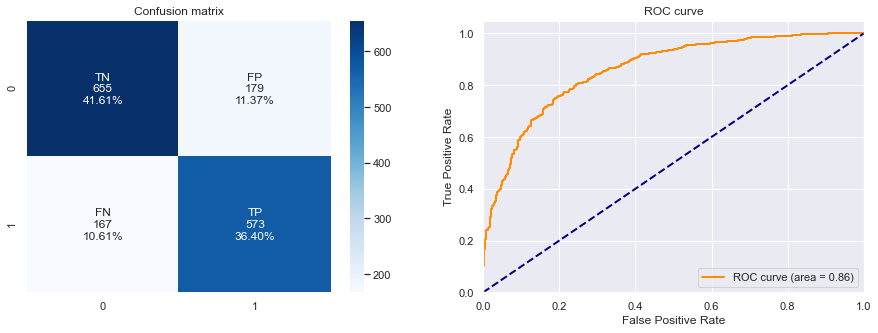

0,780
0,208
0,761
0,774
0,768
0,860


(0.7801778907242694,
 0.20893719806763278,
 0.761968085106383,
 0.7743243243243243,
 0.7680965147453083,
 0.8604980880160737)

In [139]:
print('mlp + user + tfidf')
hl,bs,al,lri = utils.random_search_mlp(X_train,y_train,n_iter=10)
clf = utils.optimized_mlp(hl,bs,al,lri)
clf.fit(X_train, y_train)

y_prob = clf.predict_proba(X_test)[:,1]
y_prob_train = clf.predict_proba(X_train)[:,1]
# threshold moving

thr = utils.optimal_threshold(y_prob_train, y_train)
print(thr)
y_pred = [1 if p >= thr else 0 for p in y_prob]
utils.get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)